In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as hcl
from scipy.spatial.distance import squareform 
from collections import Counter
from colour import Color
from sklearn.preprocessing import normalize


##### Ward's clustering

path = "~/Dropbox/school/test/Networks/ICIO_data/"

def extract_symmetrize_for_countries(year, countries):
    input_output = pd.read_csv(path + "ICIO2016_" + str(year) + ".csv", index_col = [0,1], header = [0,1])
    smpl_cntrs = countries
    input_output = input_output.loc[smpl_cntrs]
    input_output = input_output[smpl_cntrs]
    sym_matrix = input_output.as_matrix()
    # Make it symmetric by adding it to its transpose
    sym_matrix = sym_matrix + np.transpose(sym_matrix)
    # Convert to DataFrame
    sym_matrix = pd.DataFrame(sym_matrix)
    sym_matrix.index = input_output.index
    sym_matrix.columns = input_output.columns
    return sym_matrix
    
def get_clusters(sym_matrix, cluster_target):
    # Invert every cell to make it a distance matrix
    inv_matrix = [[1/(1+i) for i in row] for row in sym_matrix.as_matrix()]
    # Convert to matrix
    inv_matrix = np.asmatrix(inv_matrix)
    # Fill diagonal to zero (requirement)
    np.fill_diagonal(inv_matrix, 0)
    # Convert to DataFrame
    inv_matrix = pd.DataFrame(inv_matrix)
    # Assign index and columns
    inv_matrix.index = sym_matrix.index
    inv_matrix.columns = sym_matrix.columns
    # Create clusters
    linkage_matrix = hcl.ward(squareform(inv_matrix))
    clusters = hcl.cut_tree(linkage_matrix, n_clusters=cluster_target)
    clusters = [item for sublist in clusters for item in sublist]
    cluster_counter = Counter(clusters)
    num_clusters = sum([x > 1 for x in cluster_counter.values()])
    cluster_id = [key for key,value in cluster_counter.items() if cluster_counter[key] > 1]
    return clusters, cluster_id, cluster_counter
    
def return_distinct_country_weights_comm(sym_matrix, clusters, cluster_id):
    distinct_cross = []
    cluster_lengths =[]
    for clust in cluster_id:
        cluster_x = [i for i,x in enumerate(clusters) if x == clust]
        cluster_lengths.append(len(cluster_x))
        subsample = sym_matrix.iloc[cluster_x][cluster_x]
        distinct = []
        for i in countries:
            summing = subsample.loc[i][:].drop(i, axis = 1).sum().sum()
            distinct.append(summing)
        if subsample.sum().sum()!=0:
            distinct = sum(distinct)/subsample.sum().sum()
        else:
            distinct = 0
        distinct_cross.append(distinct)
    return distinct_cross, cluster_lengths
    
def return_distinct_sector_weights_comm(sym_matrix, clusters, cluster_id):
    distinct_cross = []
    cluster_lengths =[]
    for clust in cluster_id:
        cluster_x = [i for i,x in enumerate(clusters) if x == clust]
        cluster_lengths.append(len(cluster_x))
        subsample = sym_matrix.iloc[cluster_x][cluster_x]
        sub_sectors = [item[1] for item in subsample.index]
        distinct = []
        for i in countries:
            summing = subsample.loc[i][:].drop(i, axis = 1).sum().sum()
            distinct.append(summing)
        if subsample.sum().sum()!=0:
            distinct = sum(distinct)/subsample.sum().sum()
        else:
            distinct = 0
        distinct_cross.append(distinct)
    return distinct_cross, cluster_lengths
    
def internationalization_index(countries, cluster_target):
    distinct_cross_per_year = []
    cluster_size_per_year = []
    for year in list(range(1995,2012)):
        sym_matrix = extract_symmetrize_for_countries(year, countries)
        clusters, cluster_id, cluster_counter = get_clusters(sym_matrix, cluster_target)
        distinct_cross, cluster_lengths = return_distinct_country_weights_comm(sym_matrix,clusters,cluster_id)
        distinct_cross = [a*b for a,b in zip(distinct_cross,cluster_lengths)]
        distinct_cross = sum(distinct_cross)/sum(cluster_lengths)
        cluster_lengths = np.median(cluster_lengths)
        distinct_cross_per_year.append(distinct_cross)
        cluster_size_per_year.append(cluster_lengths)
    return distinct_cross_per_year, cluster_size_per_year

    
def return_clusters(sym_matrix, clusters, cluster_num):
    cluster_x = [i for i,x in enumerate(clusters) if x == cluster_num]
    subsample = sym_matrix.iloc[cluster_x][cluster_x]
    return subsample

In [65]:
def normalize_table(df, cutoff=0):
    result = df.copy()
    for feature_name in df.columns:
        total = df[feature_name].sum()
        if total == 0:
            result = result.drop(feature_name,1)
            result = result.drop(feature_name,0)
        else: 
            result[feature_name] = df[feature_name] / total
    result[result<cutoff] = 0
    return result 

In [29]:
countries = ['BEL', 'LUX', 'NLD', 'FRA', 'GBR', 'DEU', 'AUT', 'ITA', 'ESP', 'PRT', 'IRL', 'DNK', 'SWE', 'FIN', 'GRC',
             'CZE', 'EST', 'HUN', 'LVA', 'POL', 'SVK', 'SVN', 'BGR', 'HRV', 'CYP', 'LTU', 'MLT', 'ROU',
             'AUS', 'CAN', 'CHL', 'ISL', 'ISR', 'JPN', 'KOR', 'MEX', 'NZL', 'NOR', 'CHE', 'TUR', 'USA',
             'ARG', 'BRA', 'BRN', 'KHM', 'TWN', 'CHN', 'COL', 'CRI', 'HKG', 'IND', 'IDN', 'MYS', 'MAR', 'PER',
             'PHL','RUS', 'SAU', 'SGP', 'ZAF', 'THA', 'TUN', 'VNM', 'ROW']
sym_matrix = extract_symmetrize_for_countries(2011, countries)
clusters, cluster_id, cluster_counter = get_clusters(sym_matrix, 64)
subsample = return_clusters(sym_matrix, clusters, 0)

In [32]:
import operator
max(cluster_counter.iteritems(), key=operator.itemgetter(1))

(8, 82)

In [33]:
min(cluster_counter.iteritems(), key=operator.itemgetter(1))

(23, 11)

In [40]:
subsample = normalize(subsample, 0.3)
subsample = return_clusters(sym_matrix, clusters, 8)

sample_matrix = subsample.as_matrix()

sample_out = np.sum(sample_matrix, axis=1) 
#sample_betweeness_centrality = nx.edge_betweenness_centrality(G)

D = nx.Graph(sample_matrix)
#D = nx.Graph(sample_matrix)

for node in D.nodes():
    D.node[node]['country'] = list(subsample.index[node])[0]
    D.node[node]['sector'] = list(subsample.index[node])[1]
    D.node[node]['outdegree'] = sample_out[node]
  #  D.node[node]['betweeness_centrality'] = sample_betweeness_centrality.values()[node]

#len(np.unique(nx.get_node_attributes(D, 'country').values()))

countries =np.unique(nx.get_node_attributes(D, 'country').values()) 

color_map = {}
for i in countries:
    c = Color(pick_for=i)
    color_map[i]="%s" % c

In [72]:
subsample = normalize_table(subsample, 0.8)
subsample = return_clusters(sym_matrix, clusters, 8)

sample_matrix = subsample.as_matrix()

sample_out = np.sum(sample_matrix, axis=1) 
#sample_betweeness_centrality = nx.edge_betweenness_centrality(G)

D = nx.Graph(sample_matrix)
#D = nx.Graph(sample_matrix)

for node in D.nodes():
    D.node[node]['country'] = list(subsample.index[node])[0]
    D.node[node]['sector'] = list(subsample.index[node])[1]
    D.node[node]['outdegree'] = sample_out[node]
  #  D.node[node]['betweeness_centrality'] = sample_betweeness_centrality.values()[node]

#len(np.unique(nx.get_node_attributes(D, 'country').values()))

countries =np.unique(nx.get_node_attributes(D, 'country').values()) 

color_map = {}
for i in countries:
    c = Color(pick_for=i)
    color_map[i]="%s" % c

weights = nx.get_edge_attributes(D, 'weight').values()
weights = weights / np.linalg.norm(weights)
d = nx.degree(D)

sectors = nx.get_node_attributes(D, 'sector').values()
country = nx.get_node_attributes(D, 'country').values()
cnt_sec = []
for i,j in zip(country,sectors):
    a = [i,j]
    cnt_sec.append(a)
for i,node in enumerate(D.nodes()):
    D.node[node]['cnt_sec'] = cnt_sec[i]

map_labels = nx.get_node_attributes(D, 'cnt_sec')  
plt.figure(figsize = (120,120))

nx.draw(D,node_color = [color_map[D.node[node]['country']] for node in D], labels=map_labels,width = weights,node_size=[v * 100 for v in d.values()])
#nx.draw(D, width = weights*20,labels =map_labels)# ,node_color = [color_map[D.node[node]['country']] for node in D])#,node_size=[v * 100 for v in d.values()])
plt.title('Global Value Chains Sample Network')

#france = mpatches.Patch(color = 'b', label = 'France')
#britain =  mpatches.Patch(color = '#FF0099', label = 'Great Britain')
#germany =  mpatches.Patch(color = '#660066', label = 'Germany')
#spain = mpatches.Patch(color = '#FF33CC', label = 'Spain')
#romania = mpatches.Patch(color = 'r', label = 'Romania')
#cyprus = mpatches.Patch(color='#996600', label='Cyprus')

#plt.legend(handles=[france, britain, germany,spain,romania,cyprus], prop={'size':150})
#plt.savefig('5countreis complete graph.png')
plt.show()

In [55]:
color_map['ARG']

'#5ad57e'

In [81]:
D.

2419.1369999999997

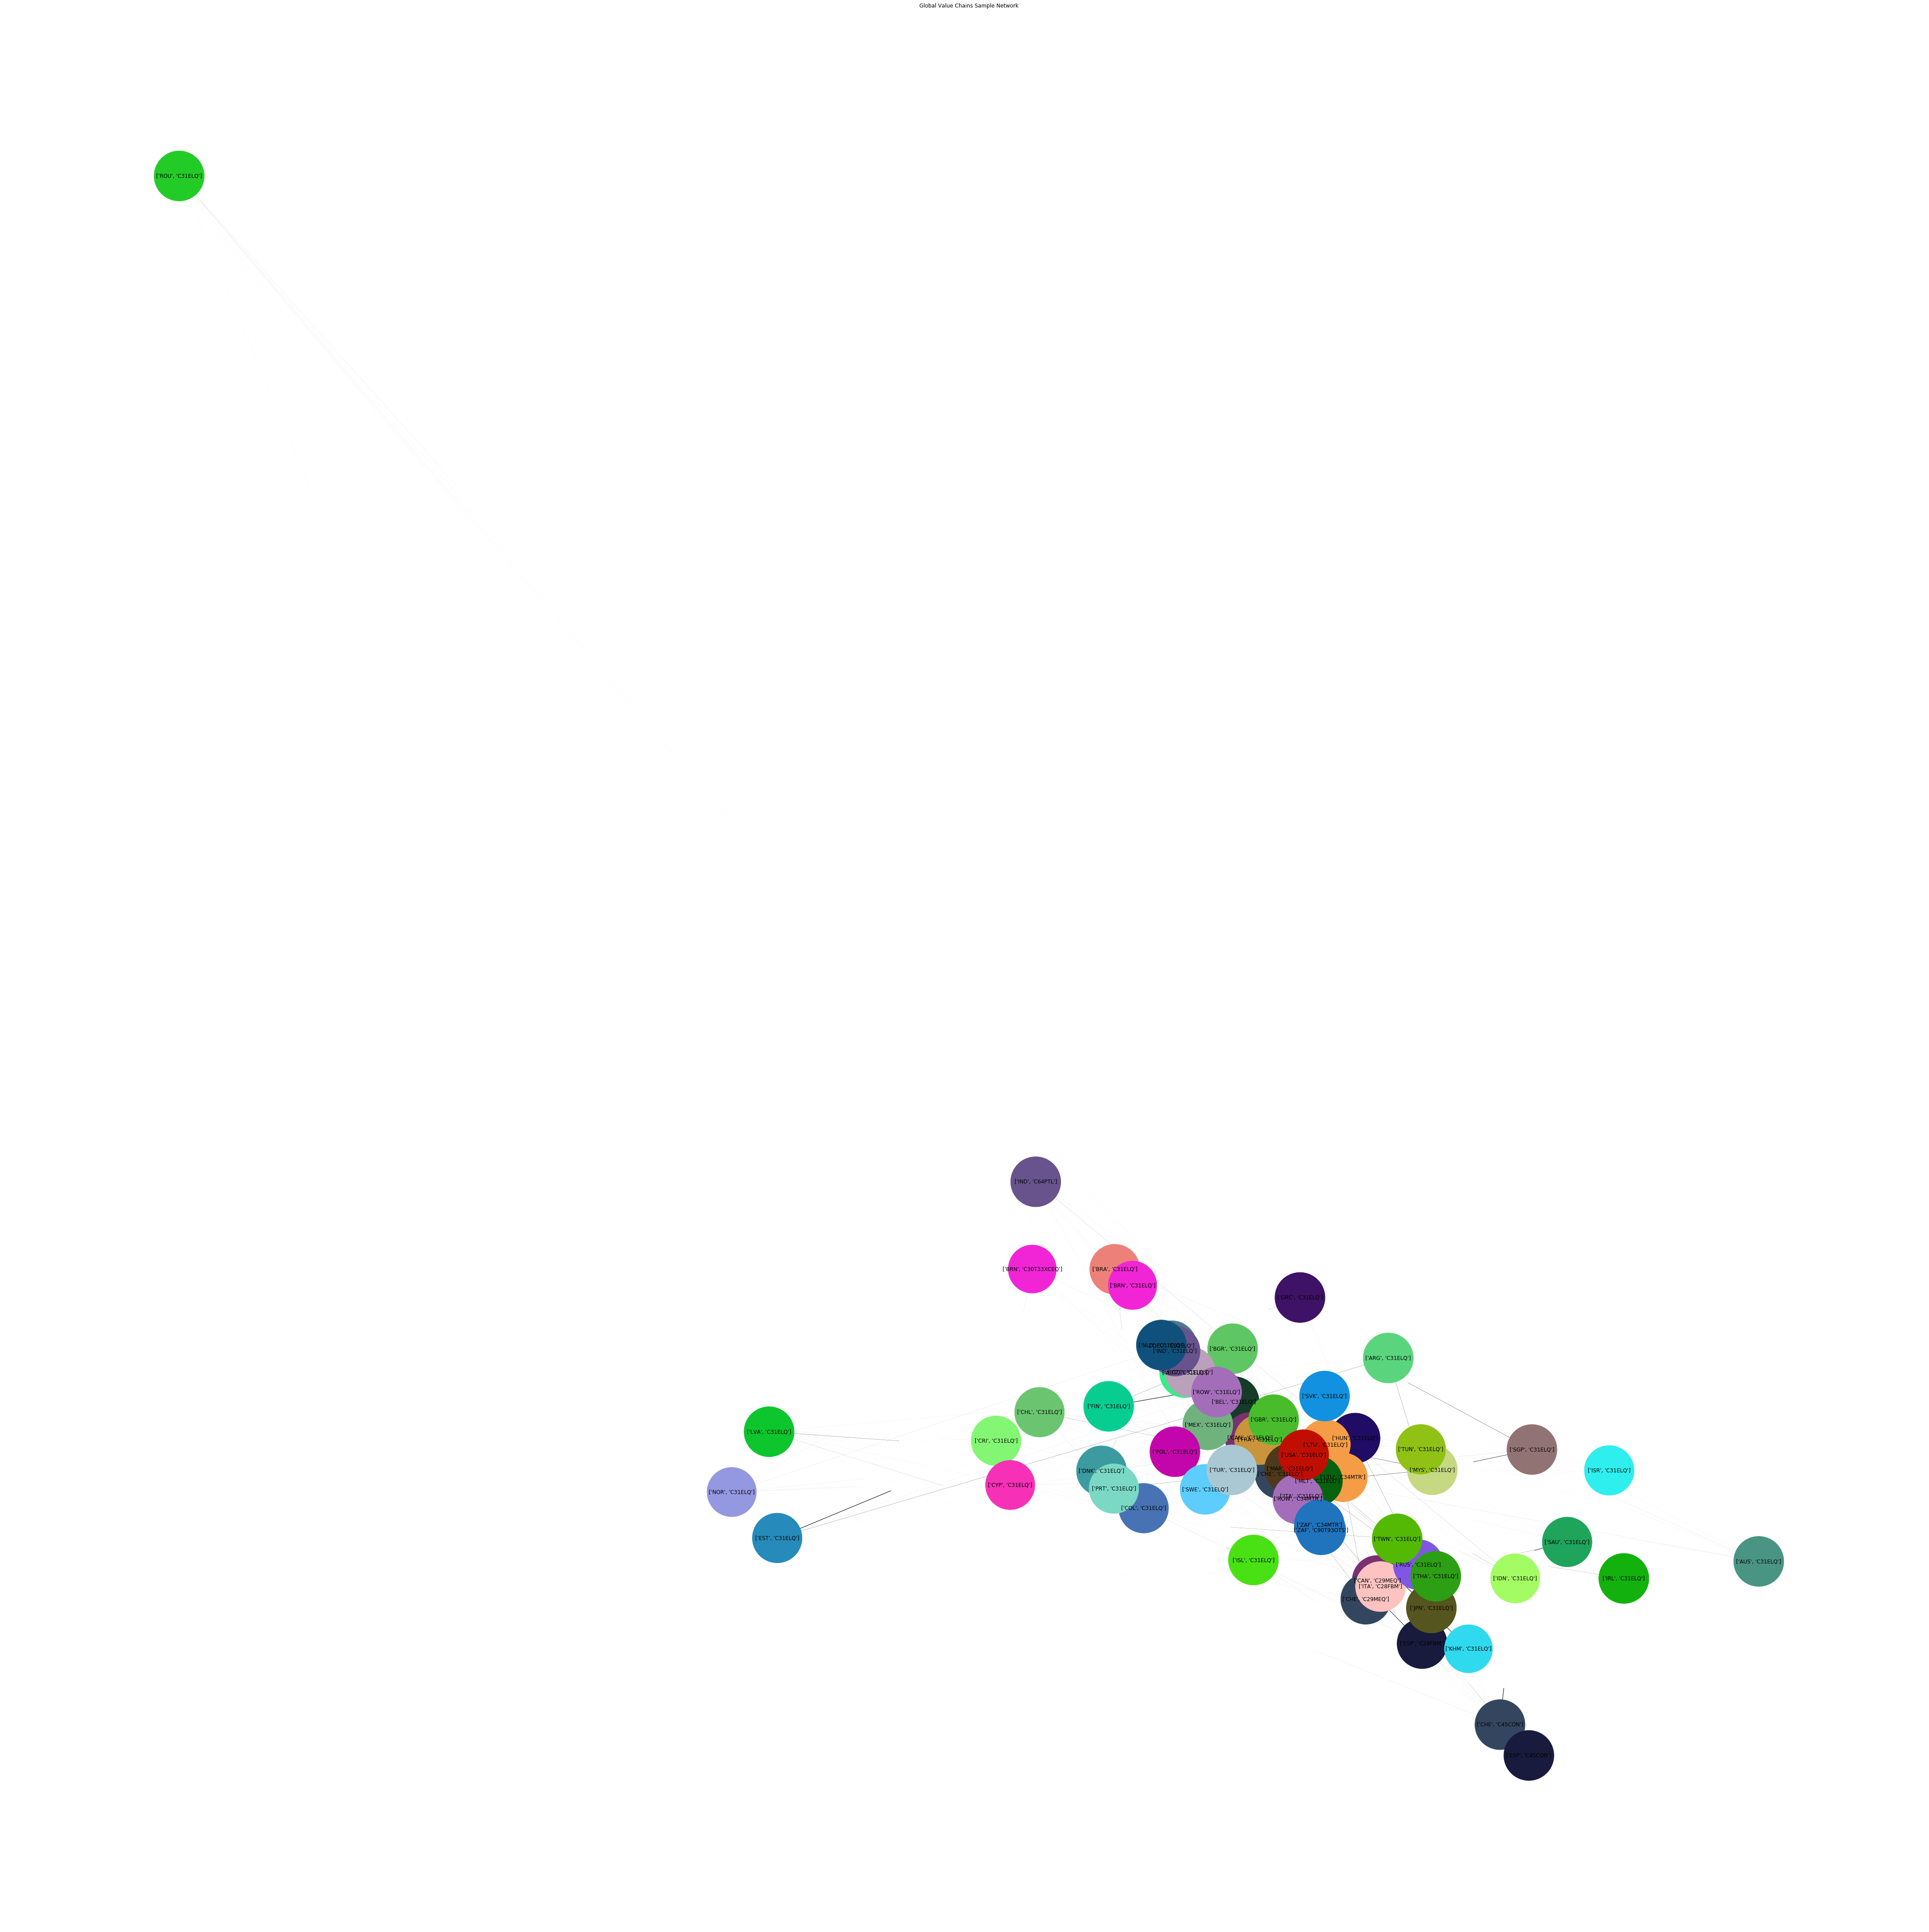

In [89]:

subsample = normalize_table(subsample, 0.6)
subsample = return_clusters(sym_matrix, clusters, 11)

sample_matrix = subsample.as_matrix()

sample_out = np.sum(sample_matrix, axis=1) 
#sample_betweeness_centrality = nx.edge_betweenness_centrality(G)

#D = nx.Graph(sample_matrix)
D = nx.DiGraph(sample_matrix)
outdeg = D.out_degree()
to_remove = [n for n in outdeg if outdeg[n] == 1]
D.remove_nodes_from(to_remove)


#D = nx.Graph(sample_matrix)

for node in D.nodes():
    D.node[node]['country'] = list(subsample.index[node])[0]
    D.node[node]['sector'] = list(subsample.index[node])[1]
    D.node[node]['outdegree'] = sample_out[node]
  #  D.node[node]['betweeness_centrality'] = sample_betweeness_centrality.values()[node]

#len(np.unique(nx.get_node_attributes(D, 'country').values()))

countries =np.unique(nx.get_node_attributes(D, 'country').values()) 

color_map = {}
for i in countries:
    c = Color(pick_for=i)
    color_map[i]="%s" % c

weights = nx.get_edge_attributes(D, 'weight').values()
weights = weights / np.linalg.norm(weights)
d = nx.degree(D)

sectors = nx.get_node_attributes(D, 'sector').values()
country = nx.get_node_attributes(D, 'country').values()
cnt_sec = []
for i,j in zip(country,sectors):
    a = [i,j]
    cnt_sec.append(a)
for i,node in enumerate(D.nodes()):
    D.node[node]['cnt_sec'] = cnt_sec[i]

map_labels = nx.get_node_attributes(D, 'cnt_sec')  
plt.figure(figsize = (60,60))
pos = nx.shell_layout(D)
nx.draw(D,node_color = [color_map[D.node[node]['country']] for node in D], labels=map_labels,width = weights,node_size=[v * 100 for v in d.values()])
#nx.draw(D, width = weights*20,labels =map_labels)# ,node_color = [color_map[D.node[node]['country']] for node in D])#,node_size=[v * 100 for v in d.values()])
plt.title('Global Value Chains Sample Network')

#france = mpatches.Patch(color = 'b', label = 'France')
#britain =  mpatches.Patch(color = '#FF0099', label = 'Great Britain')
#germany =  mpatches.Patch(color = '#660066', label = 'Germany')
#spain = mpatches.Patch(color = '#FF33CC', label = 'Spain')
#romania = mpatches.Patch(color = 'r', label = 'Romania')
#cyprus = mpatches.Patch(color='#996600', label='Cyprus')

#plt.legend(handles=[france, britain, germany,spain,romania,cyprus], prop={'size':150})
#plt.savefig('5countreis complete graph.png')
plt.show()

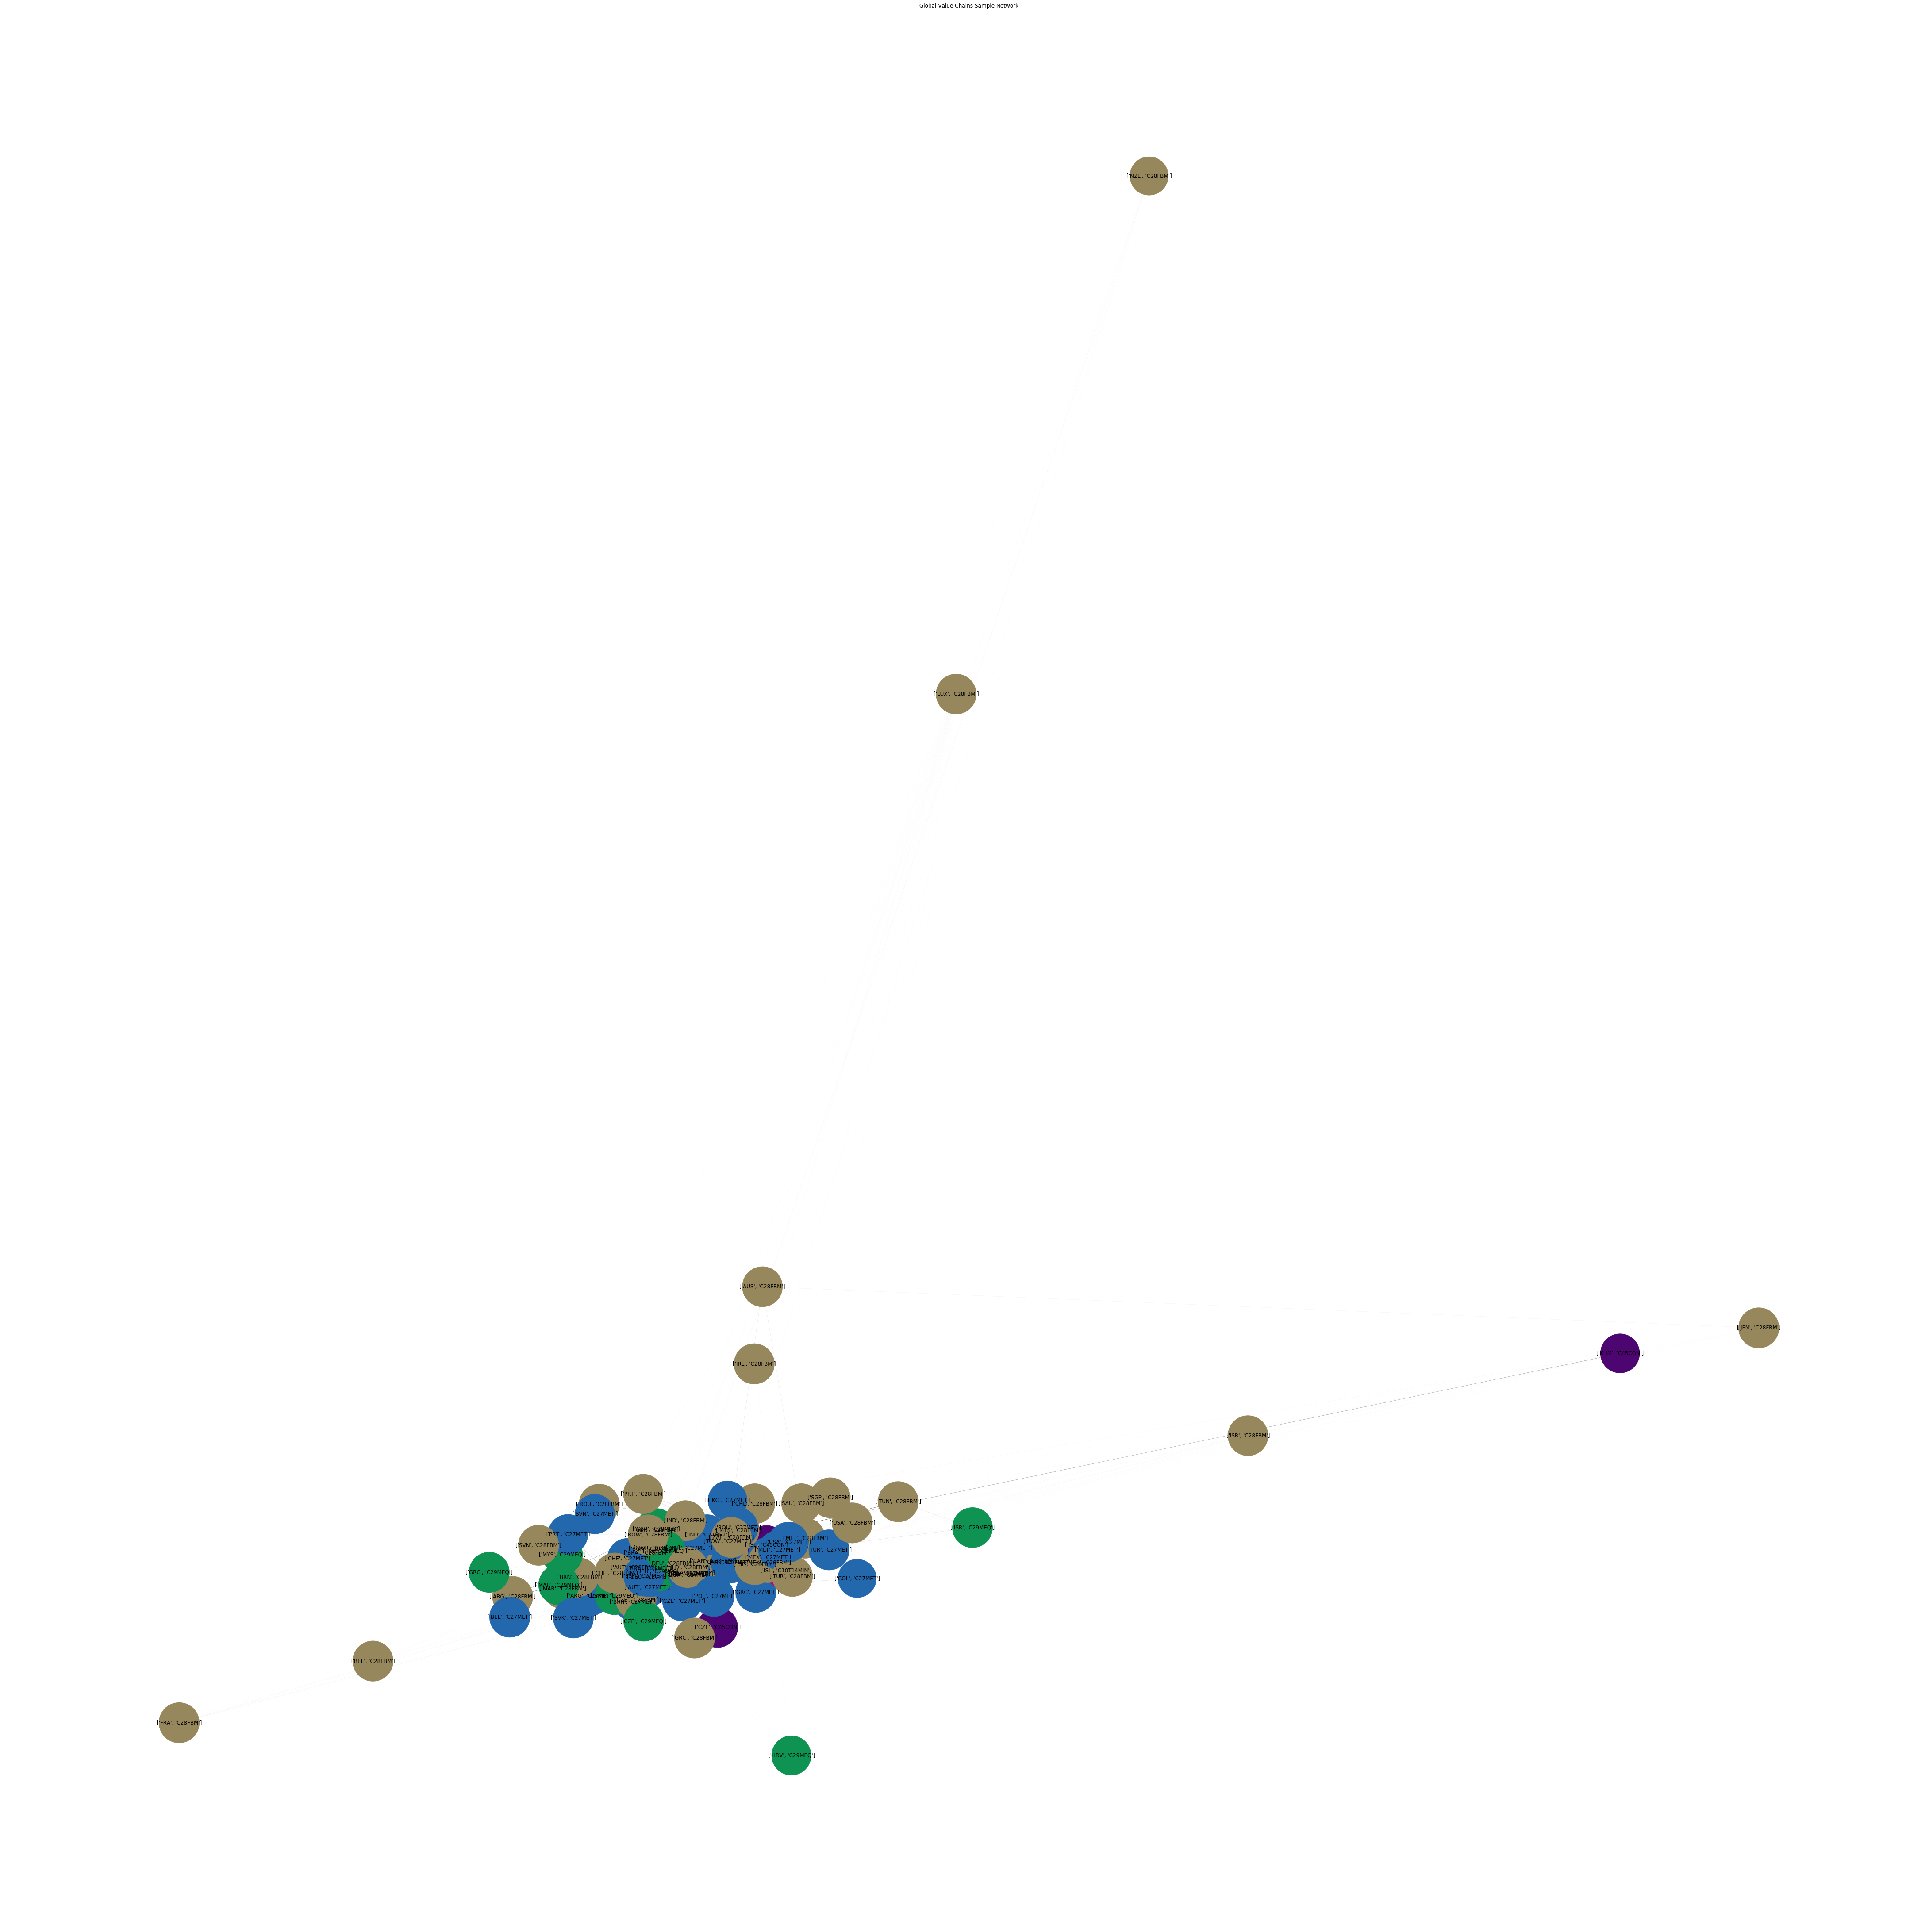

In [93]:


    
subsample = normalize_table(subsample, 0.8)
subsample = return_clusters(sym_matrix, clusters, 8)

sample_matrix = subsample.as_matrix()

sample_out = np.sum(sample_matrix, axis=1) 
#sample_betweeness_centrality = nx.edge_betweenness_centrality(G)

D = nx.Graph(sample_matrix)
#D = nx.Graph(sample_matrix)

for node in D.nodes():
    D.node[node]['country'] = list(subsample.index[node])[0]
    D.node[node]['sector'] = list(subsample.index[node])[1]
    D.node[node]['outdegree'] = sample_out[node]
  #  D.node[node]['betweeness_centrality'] = sample_betweeness_centrality.values()[node]

countries =np.unique(nx.get_node_attributes(D, 'country').values()) 
sectors = np.unique(nx.get_node_attributes(D, 'sector').values())


color_map = {}
for i in countries:
    c = Color(pick_for=i)
    color_map[i]="%s" % c
    
color_sector = {}
for i in sectors:
    c = Color(pick_for=i)
    color_sector[i]="%s" % c

#len(np.unique(nx.get_node_attributes(D, 'country').values()))

countries =np.unique(nx.get_node_attributes(D, 'country').values()) 

color_map = {}
for i in countries:
    c = Color(pick_for=i)
    color_map[i]="%s" % c

weights = nx.get_edge_attributes(D, 'weight').values()
weights = weights / np.linalg.norm(weights)
d = nx.degree(D)

sectors = nx.get_node_attributes(D, 'sector').values()
country = nx.get_node_attributes(D, 'country').values()
cnt_sec = []
for i,j in zip(country,sectors):
    a = [i,j]
    cnt_sec.append(a)
for i,node in enumerate(D.nodes()):
    D.node[node]['cnt_sec'] = cnt_sec[i]

map_labels = nx.get_node_attributes(D, 'cnt_sec')  
plt.figure(figsize = (60,60))
pos = nx.shell_layout(D)

nx.draw(D,node_color = [color_sector[D.node[node]['sector']] for node in D], labels=map_labels,width = weights,node_size=[v * 100 for v in d.values()])
#nx.draw(D, width = weights*20,labels =map_labels)# ,node_color = [color_map[D.node[node]['country']] for node in D])#,node_size=[v * 100 for v in d.values()])
plt.title('Global Value Chains Sample Network')

#france = mpatches.Patch(color = 'b', label = 'France')
#britain =  mpatches.Patch(color = '#FF0099', label = 'Great Britain')
#germany =  mpatches.Patch(color = '#660066', label = 'Germany')
#spain = mpatches.Patch(color = '#FF33CC', label = 'Spain')
#romania = mpatches.Patch(color = 'r', label = 'Romania')
#cyprus = mpatches.Patch(color='#996600', label='Cyprus')

#plt.legend(handles=[france, britain, germany,spain,romania,cyprus], prop={'size':150})
#plt.savefig('5countreis complete graph.png')

plt.show()